In [115]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import linregress, ttest_ind


# Merging Data & Exploratory Data Analysis


(340, 45)
             budget             id  popularity       revenue   runtime_x  \
count  3.400000e+02     340.000000  340.000000  3.400000e+02  340.000000   
mean   3.748653e+07   42616.805882   42.337717  1.692944e+08  114.614706   
std    5.415082e+07   75305.127396   48.699693  2.629942e+08   24.105993   
min    0.000000e+00      11.000000    0.335195  0.000000e+00   63.000000   
25%    2.040236e+06     883.250000   14.263084  1.025791e+07   98.000000   
50%    1.500000e+07   10389.500000   29.928423  5.961214e+07  110.000000   
75%    4.400000e+07   43439.250000   56.553015  1.871199e+08  126.000000   
max    2.600000e+08  354110.000000  481.098624  1.845034e+09  219.000000   

       vote_average    vote_count   Unnamed: 0         year  critic_score  \
count    340.000000    340.000000   340.000000   340.000000    340.000000   
mean       7.070588   1676.264706   762.420588  1993.732353     87.394118   
std        0.757160   2080.800820   543.688888    22.593669     18.371228 

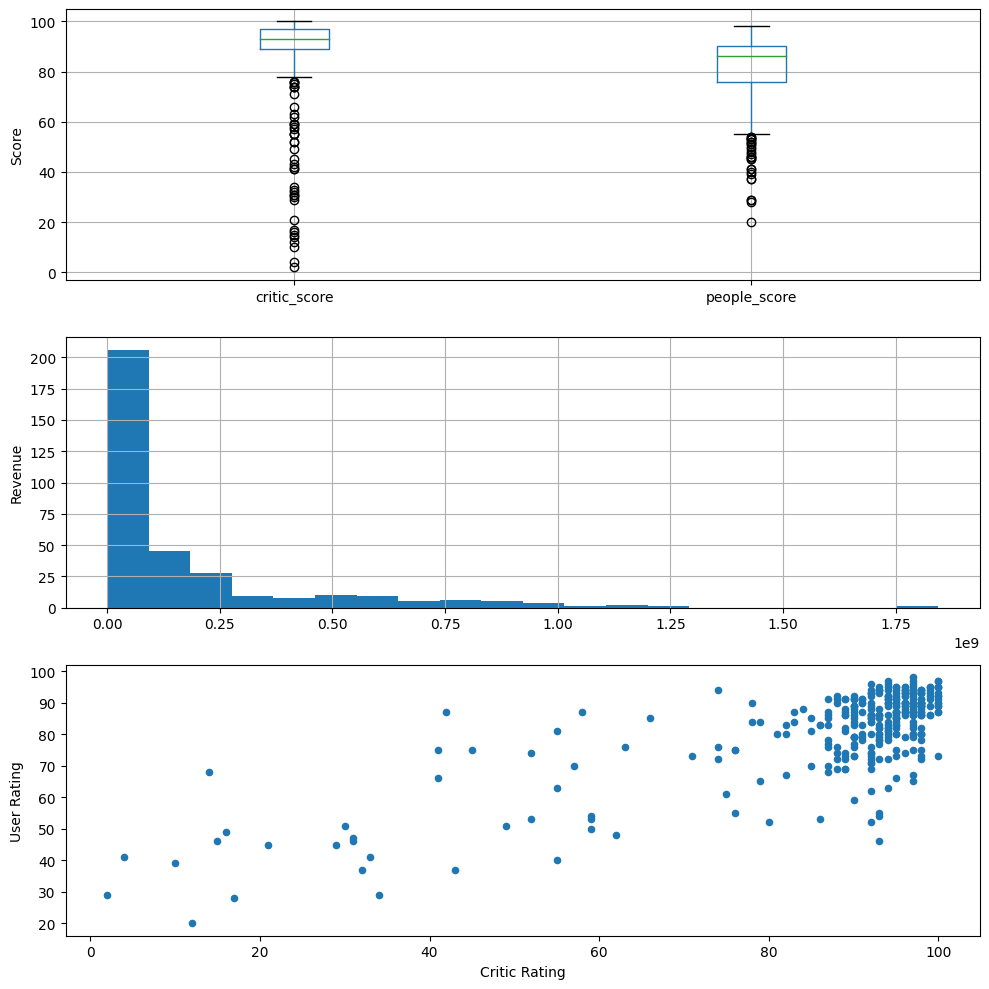

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# reading the data
data_tmdb = pd.read_csv("../data/tmdb_5000_movies.csv")
data_rt = pd.read_csv("../data/rotten_tomatoes_top_movies.csv")

# converting object column into numerical column for runtime
data_rt['hours'] = data_rt['runtime'].str.extract(
    '(\d+)h', expand=False).fillna(0).astype(float)
data_rt['minutes'] = data_rt['runtime'].str.extract(
    '(\d+)m', expand=False).fillna(0).astype(float)
data_rt['runtime'] = data_rt['hours'] * 60 + data_rt['minutes']
data_rt = data_rt.drop(['hours', 'minutes'], axis=1)

# removing duplicates in both datasets
data_tmdb = data_tmdb.drop_duplicates(subset='title')
data_rt = data_rt.drop_duplicates(subset='title')

# merging the data
movies = pd.merge(data_tmdb, data_rt, on=['title'], how='inner')

# exploratory data analysis
print(movies.shape)
# print(movies.dtypes)
print(movies.describe())

# handling missing data
# print(movies.isnull().sum())

# removing leading/trailing whitespace from column names
movies.columns = movies.columns.str.strip()

# removing unnecessary columns
movies = movies.drop(['homepage', 'Unnamed: 0', 'consensus', 'link', 'status', 'release_date_(theaters)',
                    # 'original_language_x', 'spoken_languages',
                    'rating', 'tagline',
                     'original_language_y', 'producer', 'writer', 'director', 'release_date_(streaming)', 'production_co', 'sound_mix', 'aspect_ratio', 'view_the_collection'], axis=1)

# checking for abnormalities
abnormal_critic_scores = movies[(
    movies['critic_score'] > 100) | (movies['critic_score'] < 0)]
if not abnormal_critic_scores.empty:
    print("Abnormal values found in critic_score column:\n", abnormal_critic_scores)

abnormal_people_scores = movies[(
    movies['people_score'] > 100) | (movies['people_score'] < 0)]
if not abnormal_people_scores.empty:
    print("Abnormal values found in people_score column:\n", abnormal_people_scores)

# extracting year from the release date
movies['year'] = pd.to_datetime(movies['release_date']).dt.year

movies.to_csv("../data/movies.csv", index=False)

# some basic visualizations
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# boxplot for critic_score and people_score
movies[['critic_score', 'people_score']].boxplot(ax=axes[0])
axes[0].set_ylabel('Score')

# histogram of movie revenue
movies['revenue'].hist(ax=axes[1], bins=20)
axes[1].set_ylabel('Revenue')

# scatter plot of critic_score vs people_score
movies.plot.scatter(x='critic_score', y='people_score', ax=axes[2])
axes[2].set_xlabel('Critic Rating')
axes[2].set_ylabel('User Rating')

plt.tight_layout()

plt.show()


# OLS Regression Analysis for Hypothesis Testing


In [54]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# download data
movies = pd.read_csv("../data/movies.csv")

# perform ordinary least squares regression analysis
model = smf.ols('revenue ~ critic_score', data=movies).fit()
summary = model.summary()
print(summary)

# store information into a dataframe
results = {}
results['R-squared'] = model.rsquared
results['Prob (F-statistic)'] = model.f_pvalue
results['Coefficients'] = model.params.to_dict()
results['Standard errors'] = model.bse.to_dict()
results['t-values'] = model.tvalues.to_dict()
results['p-values'] = model.pvalues.to_dict()

results = pd.DataFrame(results)

# checking how much the variance describes the data
print(
    f"The variance explained by the linear regression model is {round(results['R-squared'][0] * 100, 2)}%\n")

# checking the p-value for hypothesis testing on intercept and coefficient of critic_score
alpha = 0.05
if results['Prob (F-statistic)'][0] > alpha:
    print(
        f"The p-value for the F-statistic is greater than {alpha}, so we cannot reject the null hypothesis.")
    print(f"Null hypothesis: There is no statistically significant relationship between critic_score and revenue.\n")
else:
    print(
        f"The p-value for the F-statistic is less than or equal to {alpha}, so we can reject the null hypothesis.")
    print(f"Alternative hypothesis: There is a statistically significant relationship between critic_score and revenue.\n")


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.634
Date:                Tue, 04 Apr 2023   Prob (F-statistic):             0.0104
Time:                        22:47:37   Log-Likelihood:                -7070.4
No. Observations:                 340   AIC:                         1.414e+04
Df Residuals:                     338   BIC:                         1.415e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.284e+06   6.89e+07     -0.062   

In [49]:
movies.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime_x', 'title', 'vote_average',
       'vote_count', 'year', 'synopsis', 'critic_score', 'people_score',
       'total_reviews', 'total_ratings', 'type', 'genre',
       'box_office_(gross_usa)', 'runtime_y', 'crew'],
      dtype='object')

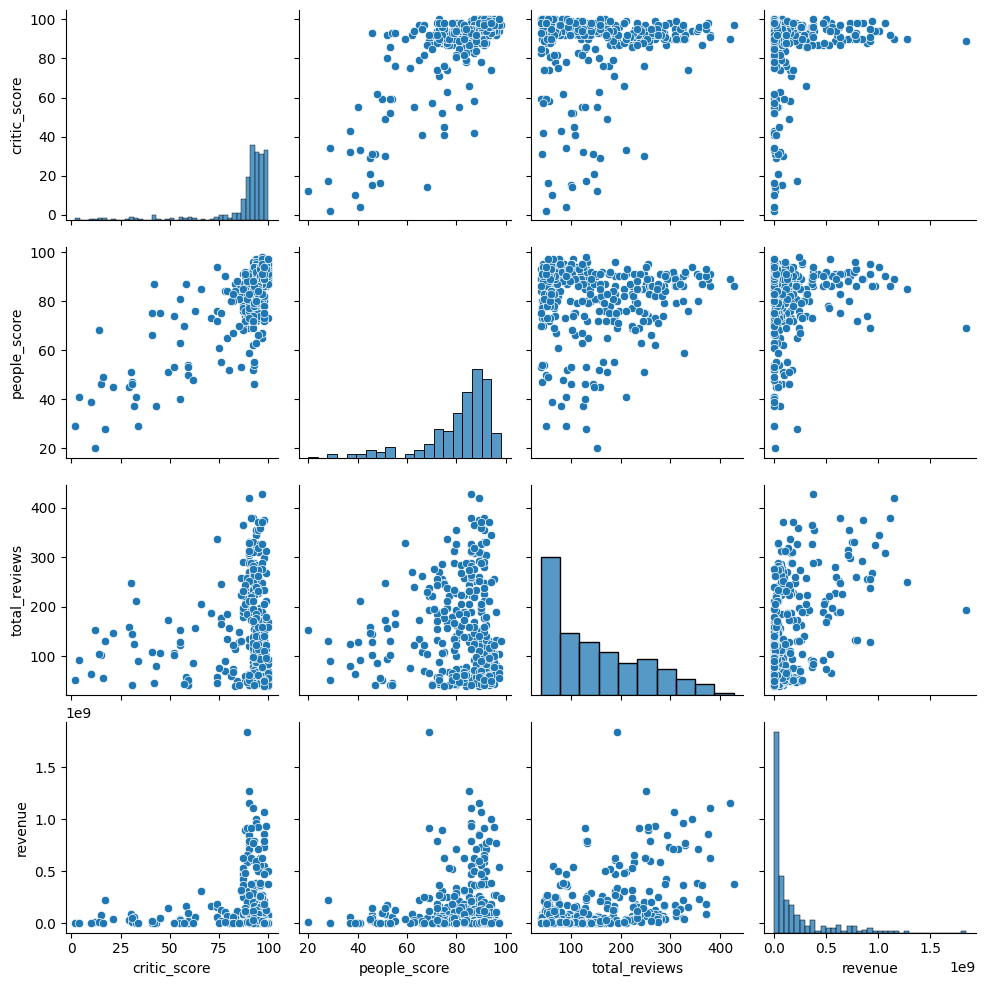

In [50]:
sns.pairplot(data=movies,
            vars=['critic_score', 'people_score', 'total_reviews', 'revenue'])

In [51]:
model_review = smf.ols('revenue ~ total_reviews', data=movies).fit()
summary_review = model_review.summary()
print(summary_review)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     95.99
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           4.11e-20
Time:                        22:33:26   Log-Likelihood:                -7031.2
No. Observations:                 340   AIC:                         1.407e+04
Df Residuals:                     338   BIC:                         1.407e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.727e+07   2.37e+07     -1.151

In [53]:
model_review_pp = smf.ols('revenue ~ total_reviews * people_score', data=movies).fit()
summary_review_pp = model_review_pp.summary()
print(summary_review_pp)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     39.97
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           4.08e-22
Time:                        22:35:38   Log-Likelihood:                -7021.8
No. Observations:                 340   AIC:                         1.405e+04
Df Residuals:                     336   BIC:                         1.407e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [44]:
model_complex = smf.ols('revenue ~ total_reviews * people_score * critic_score', data=movies).fit()
summary_complex = model_complex.summary()
print(summary_complex)

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     17.56
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           8.50e-20
Time:                        22:18:42   Log-Likelihood:                -7020.2
No. Observations:                 340   AIC:                         1.406e+04
Df Residuals:                     332   BIC:                         1.409e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

# Hypothesis Testing Using ANOVA Against Various Columns


In [56]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(42)

# load the dataset
movies = pd.read_csv('../data/movies.csv')

# specify the linear model formula
formula = 'revenue ~ C(genre)'
# formula = 'critic_score ~ C(genre)'

# fit the linear model using the specified formula
model = smf.ols(formula, movies).fit()

# calculate ANOVA table statistics
anova_table = sm.stats.anova_lm(model, type=2)

# perform hypothesis test using p-value from ANOVA table
alpha = 0.05
p_value = anova_table['PR(>F)'][0]

if p_value > alpha:
    print("Fail to reject the null hypothesis that the mean revenue is equal across different genres.")
else:
    print("Reject the null hypothesis that the mean revenue is equal across different genres.")

# display the ANOVA table
print(anova_table)


Reject the null hypothesis that the mean revenue is equal across different genres.
             df        sum_sq       mean_sq         F        PR(>F)
C(genre)  142.0  1.919913e+19  1.352052e+17  6.269937  2.430681e-31
Residual  197.0  4.248116e+18  2.156404e+16       NaN           NaN


In [61]:
movies['genre']

0      musical, comedy, fantasy, animation, kids and ...
1                             western, adventure, action
2                                     adventure, fantasy
3                                drama, history, romance
4                             adventure, fantasy, action
                             ...                        
335                                              western
336                              musical, romance, drama
337                                               horror
338                                          documentary
339                                          documentary
Name: genre, Length: 340, dtype: object

<Axes: xlabel='genre', ylabel='revenue'>

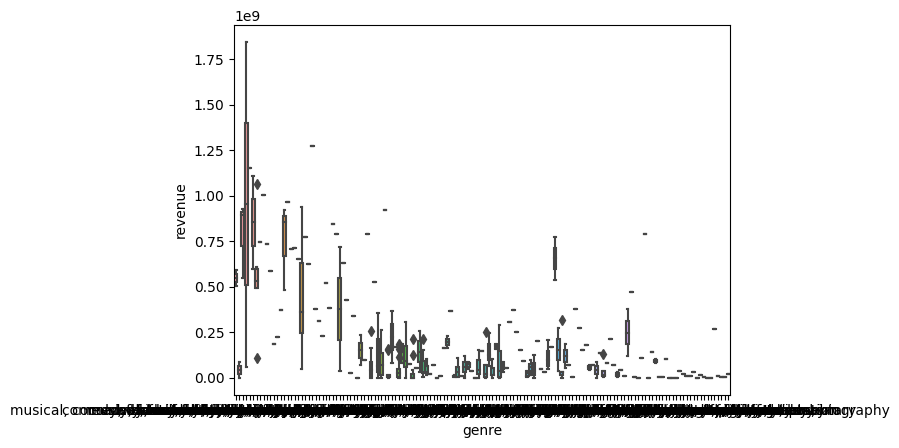

In [58]:
sns.boxplot(x="genre", y="revenue", data=movies)

# Creating Regression Analysis & Plots for Finding Relationships


This is testing year against critic_score
Slope: -0.20062621374986706
Intercept: 487.7443172620178
Correlation coefficient: -0.2278305073530882
P-value: 2.221034584673111e-05
Standard error of the regression: 0.046638328738923714

This is testing year against people_score
Slope: -0.19310208835793022
Intercept: 466.5828440890979
Correlation coefficient: -0.2883333423074135
P-value: 6.218532499350183e-08
Standard error of the regression: 0.03488077992418191

This is testing runtime_x against critic_score
Slope: 0.023958418607669223
Intercept: 84.64813054493452
Correlation coefficient: 0.031437281210883135
P-value: 0.5634782540372791
Standard error of the regression: 0.041432401387962024

This is testing runtime_x against people_score
Slope: 0.10722419314235265
Intercept: 68.95758946304606
Correlation coefficient: 0.18499641549897047
P-value: 0.0006075073312786748
Standard error of the regression: 0.03098199652592387

This is testing revenue against critic_score
Slope: 9.691654349473683e-

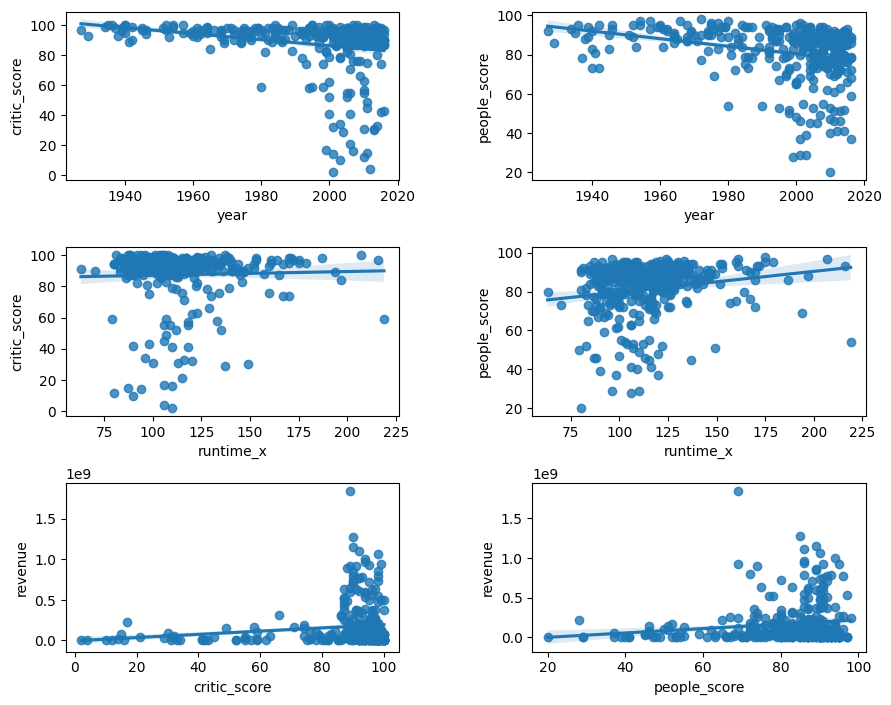

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# importing data
movies = pd.read_csv("../data/movies.csv")

f, axes = plt.subplots(3, 2, figsize=(10, 8))

# plotting each and every relevant relationship
sns.regplot(data=movies, x='year', y='critic_score', ax=axes[0, 0])
sns.regplot(data=movies, x='year', y='people_score', ax=axes[0, 1])
sns.regplot(data=movies, x='runtime_x', y='critic_score', ax=axes[1, 0])
sns.regplot(data=movies, x='runtime_x', y='people_score', ax=axes[1, 1])
# sns.regplot(data=movies, x='revenue', y='critic_score', ax=axes[2, 0])
# sns.regplot(data=movies, x='revenue', y='people_score', ax=axes[2, 1])
sns.regplot(data=movies, x='critic_score', y='revenue', ax=axes[2, 0])
sns.regplot(data=movies, x='people_score', y='revenue', ax=axes[2, 1]) # I added a pairplot above, and I don't think we need these last two plots here again.

iv = ['year', 'runtime_x', 'revenue']
dv = ['critic_score', 'people_score']

# loop through iv and dv to print regression results
for i, ivar in enumerate(iv):
    for j, dvar in enumerate(dv):
        slope, intercept, rvalue, pvalue, stderr = linregress(
            movies[ivar], movies[dvar])
        print(f"This is testing {ivar} against {dvar}")
        print(f"Slope: {slope}")
        print(f"Intercept: {intercept}")
        print(f"Correlation coefficient: {rvalue}")
        print(f"P-value: {pvalue}")
        print(f"Standard error of the regression: {stderr}\n")

# adjust the spacing between the subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4, hspace=0.4)

plt.show()


# Language and movies scores

In [67]:
movies.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language_x',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime_x',
       'spoken_languages', 'title', 'vote_average', 'vote_count', 'year',
       'synopsis', 'critic_score', 'people_score', 'total_reviews',
       'total_ratings', 'type', 'genre', 'box_office_(gross_usa)', 'runtime_y',
       'crew'],
      dtype='object')

/var/folders/cc/nq_hdtpj7p96y4w_f6_ryvv00000gq/T/ipykernel_54556/1059517712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_subset['language'] = movies_subset['original_language_x'].apply(lambda x: 'English' if x == 'en' else 'Non-English')


We have 313 movies in English and 27 movies in other languages.


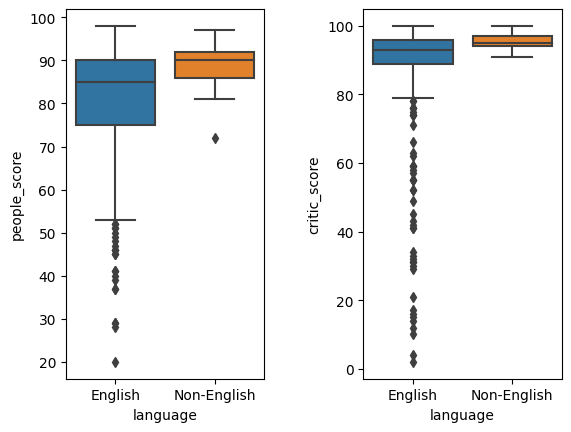

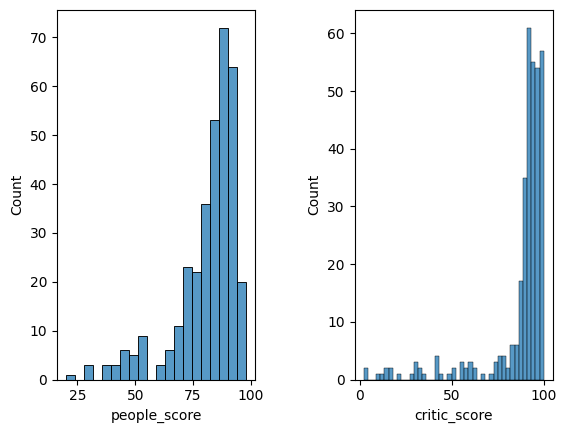

In [119]:
movies_subset = movies[['people_score', 'critic_score', 'original_language_x']]
movies_subset['language'] = movies_subset['original_language_x'].apply(lambda x: 'English' if x == 'en' else 'Non-English')
no_eng = movies_subset.language.value_counts().loc['English']
no_non_eng = movies_subset.language.value_counts().loc['Non-English']

print(f"We have {no_eng} movies in English and {no_non_eng} movies in other languages.")

vars = ['people_score', 'critic_score']
fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.5)

for i in range(len(vars)):
    ax = sns.boxplot(
        x='language',
        y=vars[i-1],
        data=movies_subset,
        ax=axs[i-1]
    )
plt.show()

fig, axs = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.5)

for i in range(len(vars)):
    ax = sns.histplot(
        x=vars[i-1],
        data=movies_subset,
        ax=axs[i-1]
    )
plt.show()

In [132]:
eng = movies_subset[movies_subset["language"] == "English"]
non_eng = movies_subset[movies_subset["language"] == "Non-English"]

for var in vars:
    print(ttest_ind(eng[var], non_eng[var]))



Ttest_indResult(statistic=-2.922231491298301, pvalue=0.0037093068591146578)
Ttest_indResult(statistic=-2.4790953990028775, pvalue=0.013658800006118115)


# JointGrid Plot for Critic Scores vs. Revenue


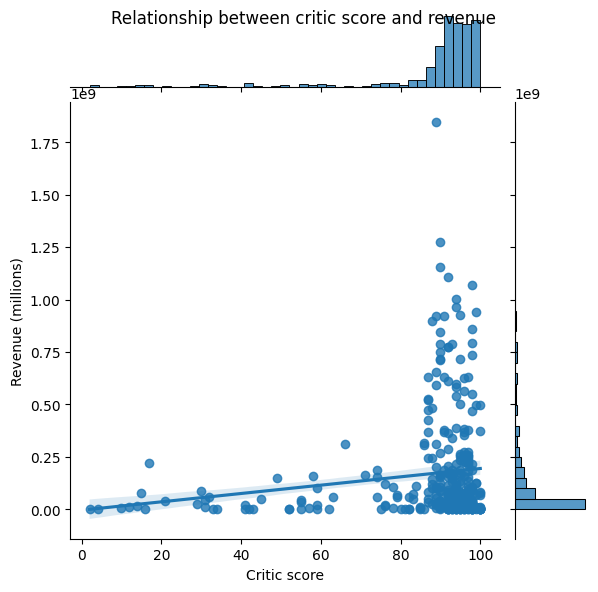

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# importing data
movies = pd.read_csv("../data/movies.csv")

# create jointgrid plot
g = sns.JointGrid(data=movies, x="critic_score", y="revenue")

# add regplot
sns.regplot(x="critic_score", y="revenue", data=movies, ax=g.ax_joint)

# add histplot
sns.histplot(x="critic_score", data=movies, ax=g.ax_marg_x, kde=False)
sns.histplot(y="revenue", data=movies, ax=g.ax_marg_y, kde=False)

# set title and axis labels
g.set_axis_labels("Critic score", "Revenue (millions)")
g.fig.suptitle("Relationship between critic score and revenue")

# show plot
plt.show()
